# ADVERSARIAL AUTOENCODER TUTORIAL

**Author** - [Yatin Dandi](https://yatindandi.github.io)

In this tutorial we will explore **Adversarial Autoencoders** (AAE), which use Generative Adversarial Networks to perform variational inference. As explained in [Adversarial Autoencoders (Makhzani et. al.)](https://arxiv.org/pdf/1511.05644), the aggregated posterior distribution of the latent representation of the autoencoder is matched to an arbitrary prior distribution using adversarial training.

The tutorial helps you with the following:

1. General workflow for implementing GAN models with inference networks using **TorchGAN**
2. Implementing custom losses with a nonstandard training loop

This tutorial assumes that your system has **Pytorch** and **torchgan** installed properly. If not, head over to the installation instructions on the [official documentation website](https://torchgan.readthedocs.io/en/latest/).

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install torchgan

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## IMPORTS

In [3]:
# General Imports
import os
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.optim import Adam
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
import torchgan.models as models
import torchgan.losses as losses
from torchgan.trainer import Trainer

In [4]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/bc/cc/b6e47b0075ca4267855d77850af7ea4194d2fc591664f1d70e5151b50637/Pillow-5.3.0-cp35-cp35m-manylinux1_x86_64.whl
newspaper3k 0.2.6 requires nltk>=3.2.1, which is not installed.
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
5.3.0


In [5]:
# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  999


## LOAD THE DATASET

We make the following transforms before feeding the **MNIST Dataset** into the networks

1. The default size of MNIST is $1 \times 28 \times 28$. However, by convention, the default input size in **torchgan.models** is a power of 2 and at least 16. Hence we shall be resizing the images to $1 \times 32 \times 32$.  One can also **zero-pad** the boundary, without any noticeable difference 

2. The output quality of GANs is improved when the images are constrained in the range The images are normalized with a mean and standard deviation of **0.5** , thereby constraining most of the inputs in the range (-1, 1)

Finally the **torchgan.trainer.Trainer** needs a **DataLoader** as input. So we are going to construct a DataLoader for the MNIST Dataset.

In [6]:
dataset = dsets.MNIST(root='./mnist', train=True,
                      transform=transforms.Compose([transforms.Resize((32, 32)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))]),
                      download=True)

In [7]:
loader = data.DataLoader(dataset, batch_size=64, shuffle=True)

## GENERATOR MODEL

The AAE Generator corresponds to the encoder of the autoencoder. It takes as input an image in the form of a torch Tensor of size $batch\ size \times 1 \times 32 \times 32$ and outputs a tuple of  reconstructed images of size $batch\ size \times 1 \times 32 \times 32$ and the encoding of size $batch\ size \times \ encoding \ dims$. The sampling of images is done by feeding the noise through the decoder. Unlike GANs, AAE allows inference of latent encodings from images which can be used for various downstream tasks. The distribution of the sampled encodings from the dataset (the aggregated posterior) is encouraged to match the prior distribution through adversarial training. Here we have implemented the deterministic version of the autoencoder which gives similar results to the variants with gaussian/universal approximator posterior as described in Adversarial Autoencoders (Makhzani et. al.)

 **For encoder**:

1. **Channel Dimension**: $input \ channels \rightarrow d \rightarrow 4d \rightarrow 16d \rightarrow \ encoding \ dims$.
2. **Image size**: $(32 \times 32) \rightarrow (16 \times 16) \rightarrow (4 \times 4) \rightarrow (1 \times 1)$

**For decoder (sampling)**:

1. **Channel Dimension**: $\ encoding \ dims \rightarrow d \rightarrow 4d \rightarrow 16d \rightarrow input \ channels$.
2. **Image size**: $(1 \times 1) \rightarrow (4 \times 4) \rightarrow (16 \times 16) \rightarrow (32 \times 32)$

LeakyReLU is used as the default nonlinearity in both the encoder and the decoder as Relu kills most of the gradients.  One can easily change the nonlinearity of the intermediate and the last layers as per their preference by passing them as parameters during initialization of the Generator object.

In [8]:
class AdversarialAutoencoderGenerator(models.Generator):
    def __init__(self, encoding_dims, input_size, input_channels, step_channels=16, nonlinearity=nn.LeakyReLU(0.2)):
        super(AdversarialAutoencoderGenerator, self).__init__(encoding_dims)
        encoder = [nn.Sequential(nn.Conv2d(input_channels, step_channels, 5, 2, 2), nonlinearity)]
        size = input_size // 2
        channels = step_channels
        while size > 1:
            encoder.append(nn.Sequential(nn.Conv2d(channels, channels * 4, 5, 4, 2), nn.BatchNorm2d(channels * 4), nonlinearity))
            channels *= 4
            size = size // 4
        self.encoder = nn.Sequential(*encoder)
        self.encoder_fc = nn.Linear(channels, encoding_dims) # Can add a Tanh nonlinearity if training is unstable as noise prior is Gaussian
        self.decoder_fc = nn.Linear(encoding_dims, step_channels)
        decoder = []
        size = 1
        channels = step_channels
        while size < input_size // 2:
            decoder.append(nn.Sequential(nn.ConvTranspose2d(channels, channels * 4, 5, 4, 2, 3), nn.BatchNorm2d(channels * 4), nonlinearity))
            channels *= 4
            size *= 4
        decoder.append(nn.ConvTranspose2d(channels, input_channels, 5, 2, 2, 1))
        self.decoder = nn.Sequential(*decoder)

    def sample(self, noise):
        noise = self.decoder_fc(noise)
        noise = noise.view(-1, noise.size(1), 1, 1)
        return self.decoder(noise)

    def forward(self, x):
        if self.training:
            encoding = self.encoder(x)
            encoding = self.encoder_fc(encoding.view(-1, encoding.size(1) * encoding.size(2) * encoding.size(3)))
            return self.sample(encoding), encoding
        else:
            return self.sample(x)

## DISCRIMINATOR NETWORK

The AAE discriminator is trained to classify an input noise vector as being real(sampled from the prior) or fake (generated by the encoder). It is thus a simple MLP which outputs the logits to be used with the minimax loss.

For reasons same as above we use a **Leaky ReLU** activation. The encoding size is halved successively till it reaches the threshold of 16. The last linear layer subsequently converts this to real output for the logit.

In [9]:
class AdversarialAutoencoderDiscriminator(models.Discriminator):
    def __init__(self, input_dims, nonlinearity=nn.LeakyReLU(0.2)):
        super(AdversarialAutoencoderDiscriminator, self).__init__(input_dims)
        model = [nn.Sequential(nn.Linear(input_dims, input_dims // 2), nonlinearity)]
        size = input_dims // 2
        while size > 16:
            model.append(nn.Sequential(nn.Linear(size, size // 2), nn.BatchNorm1d(size // 2), nonlinearity))
            size = size // 2
        model.append(nn.Linear(size, 1))
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## LOSS FUNCTIONS

The loss function of the autoencoder consists of two terms:

1. The reconstruction error: Mean squared error between the input image and the reconstruction.
2. The negative log likelihood of the generated noise (encodings) w.r.t to the discriminator.

The loss function of the discriminator consists of the minimax loss with the encodings generated by the encoder as the fake samples and the noise generated by the prior as the real samples.


In [10]:
class AdversarialAutoencoderGeneratorLoss(losses.GeneratorLoss):
    def forward(self, real_inputs, gen_inputs, dgz):
        loss = 0.999*F.mse_loss(gen_inputs, real_inputs)
        target = torch.ones_like(dgz)
        loss += 0.001*F.binary_cross_entropy_with_logits(dgz, target)
        return loss

    def train_ops(self, generator, discriminator, optimizer_generator, real_inputs, device, batch_size, labels=None):
        recon, encodings = generator(real_inputs)
        optimizer_generator.zero_grad()
        dgz = discriminator(encodings)
        loss = self.forward(real_inputs, recon, dgz)
        loss.backward()
        optimizer_generator.step()
        return loss.item()


class AdversarialAutoencoderDiscriminatorLoss(losses.DiscriminatorLoss):
    def forward(self, dx, dgz):
        target_real = torch.ones_like(dx)
        target_fake = torch.zeros_like(dx)
        loss = 0.5*F.binary_cross_entropy_with_logits(dx, target_real)
        loss += 0.5*F.binary_cross_entropy_with_logits(dgz, target_fake)
        return loss

    def train_ops(self, generator, discriminator, optimizer_discriminator, real_inputs, device, batch_size, labels=None):
        _, encodings = generator(real_inputs)
        noise = torch.randn(real_inputs.size(0), generator.encoding_dims, device=device)
        optimizer_discriminator.zero_grad()
        dx = discriminator(noise)
        dgz = discriminator(encodings)
        loss = self.forward(dx, dgz)
        loss.backward()
        optimizer_discriminator.step()
        return loss.item()
      
losses = [AdversarialAutoencoderGeneratorLoss(), AdversarialAutoencoderDiscriminatorLoss()]

## OPTIMIZERS AND HYPERPARAMETERS

The models, their corresponding optimizers and other hyperparameters like the nonlinearities to be used in the intermediate layers are bundled in the form of a dictionary and provided to the trainer for instantiation. The dictionary specifies the models that are to be trained, the optimizers associated with said models and learning rate schedulers, if any


1. "name": The class name for the model. Generally a subclass of the ```torchgan.models.Generator``` or ```torchgan.models.Discriminator```
2. "args": Arguments fed into the class during instantiation, into its constructor 
3. "optimizer": A dictionary containing the following key-value pairs defining the optimizer associated with the model
    * "name" : The class name of the optimizer. Generally an optimizer from the ```torch.optim``` package
    * "args" : Arguments to be fed to the optimizer during its instantiation, into its constructor
    * "var": Variable name for the optimizer. This is an optional argument. If this is not provided, we assign the optimizer the name ```optimizer_{}``` where {} refers to the variable name of the model.
    * "scheduler": Optional scheduler associated with the optimizer. Again this is a dictionary with the following keys
        * "name" : Class name of the scheduler
        * "args" : Arguments to be provided to the scheduler during instantiation, into its constructor

In [11]:
network = {
        'generator': {
            'name': AdversarialAutoencoderGenerator,
            'args': {
                'encoding_dims': 128,
                'input_size': 32,
                'input_channels': 1
            },
            'optimizer': {
                'name': Adam,
                'args': {
                    'lr': 0.0002,
                    'betas': (0.5, 0.999)
                }
            }
        },
        'discriminator': {
            'name': AdversarialAutoencoderDiscriminator,
            'args': {
                'input_dims': 128,
            },
            'optimizer': {
                'name': Adam,
                'args': {
                    'lr': 0.0002,
                    'betas': (0.5, 0.999)
                }
            }
        }
}

## TRAINING THE ADVERSARIAL AUTOENCODER

Next we simply feed the network descriptors and the losses we defined previously into the Trainer. Then we pass the **MNIST DataLoader** to the trainer object and wait for training to complete.

---

Important information for visualizing the performance of the GAN will be printed to the console. The best and recommended way to visualize the training is to use **tensorboardX**. It plots all the data and periodically displays the generated images. It allows us to track failure of the model early.

In [12]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 200
else:
    device = torch.device("cpu")
    epochs = 5

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 200


In [13]:
trainer = Trainer(network, losses, sample_size=64, epochs=epochs, device=torch.device('cuda:0'))
trainer(loader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
discriminator Mean Gradients : 0.04835984291632574
generator Mean Gradients : 0.15234216398874179
Mean Running Discriminator Loss : 0.6607718397178122
Mean Running Generator Loss : 0.1392901940767699
Generating and Saving Images to ./images/epoch1_generator.png



/home/yatindandi/.virtualenvs/virtual-py3/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type AdversarialAutoencoderGeneratorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yatindandi/.virtualenvs/virtual-py3/lib/python3.5/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type AdversarialAutoencoderDiscriminatorLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saving Model at './model/gan1.model'
Epoch 2 Summary
discriminator Mean Gradients : 0.20017649699915066
generator Mean Gradients : 0.0981761213517652
Mean Running Discriminator Loss : 0.5913161236975493
Mean Running Generator Loss : 0.12645774990367864
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
discriminator Mean Gradients : 0.3978579988292642
generator Mean Gradients : 0.07846985924568821
Mean Running Discriminator Loss : 0.5168398515862104
Mean Running Generator Loss : 0.12111221892493111
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
discriminator Mean Gradients : 0.5770513565929712
generator Mean Gradients : 0.06708743372349361
Mean Running Discriminator Loss : 0.45334171337772533
Mean Running Generator Loss : 0.11800428895927123
Generating and Saving Images to ./images/epoch4_generator.png

Saving Model at './model/gan4.model'
Epoch 5 Summar

Saving Model at './model/gan2.model'
Epoch 28 Summary
discriminator Mean Gradients : 36.686629328916766
generator Mean Gradients : 0.031143476154073858
Mean Running Discriminator Loss : 0.2693142306135909
Mean Running Generator Loss : 0.10660422849348322
Generating and Saving Images to ./images/epoch28_generator.png

Saving Model at './model/gan3.model'
Epoch 29 Summary
discriminator Mean Gradients : 38.50923583845514
generator Mean Gradients : 0.030807718529608532
Mean Running Discriminator Loss : 0.27369028591381
Mean Running Generator Loss : 0.1064666257858272
Generating and Saving Images to ./images/epoch29_generator.png

Saving Model at './model/gan4.model'
Epoch 30 Summary
discriminator Mean Gradients : 40.60623442327485
generator Mean Gradients : 0.03050480260966049
Mean Running Discriminator Loss : 0.27730619108374543
Mean Running Generator Loss : 0.10634457877391648
Generating and Saving Images to ./images/epoch30_generator.png

Saving Model at './model/gan0.model'
Epoch 31 Su

Saving Model at './model/gan3.model'
Epoch 54 Summary
discriminator Mean Gradients : 66.39060955836122
generator Mean Gradients : 0.025267081990547877
Mean Running Discriminator Loss : 0.36004495738409703
Mean Running Generator Loss : 0.10416292447958933
Generating and Saving Images to ./images/epoch54_generator.png

Saving Model at './model/gan4.model'
Epoch 55 Summary
discriminator Mean Gradients : 67.06166742457566
generator Mean Gradients : 0.025079017582609237
Mean Running Discriminator Loss : 0.3624736281817685
Mean Running Generator Loss : 0.10409878977848985
Generating and Saving Images to ./images/epoch55_generator.png

Saving Model at './model/gan0.model'
Epoch 56 Summary
discriminator Mean Gradients : 67.84121481578401
generator Mean Gradients : 0.024898782216648853
Mean Running Discriminator Loss : 0.36515593821682973
Mean Running Generator Loss : 0.10403716945827819
Generating and Saving Images to ./images/epoch56_generator.png

Saving Model at './model/gan1.model'
Epoch 5

Saving Model at './model/gan4.model'
Epoch 80 Summary
discriminator Mean Gradients : 77.31364403441995
generator Mean Gradients : 0.021482915863159785
Mean Running Discriminator Loss : 0.4040567444240762
Mean Running Generator Loss : 0.10289830570804205
Generating and Saving Images to ./images/epoch80_generator.png

Saving Model at './model/gan0.model'
Epoch 81 Summary
discriminator Mean Gradients : 77.42302551819081
generator Mean Gradients : 0.02135784585662974
Mean Running Discriminator Loss : 0.4052424913392829
Mean Running Generator Loss : 0.10285866957153633
Generating and Saving Images to ./images/epoch81_generator.png

Saving Model at './model/gan1.model'
Epoch 82 Summary
discriminator Mean Gradients : 77.61111737081458
generator Mean Gradients : 0.021235394362814127
Mean Running Discriminator Loss : 0.4064787529202897
Mean Running Generator Loss : 0.10282000237649155
Generating and Saving Images to ./images/epoch82_generator.png

Saving Model at './model/gan2.model'
Epoch 83 S

Saving Model at './model/gan0.model'
Epoch 106 Summary
discriminator Mean Gradients : 81.81854040001899
generator Mean Gradients : 0.01876424066718499
Mean Running Discriminator Loss : 0.42880156284124954
Mean Running Generator Loss : 0.10207000739050275
Generating and Saving Images to ./images/epoch106_generator.png

Saving Model at './model/gan1.model'
Epoch 107 Summary
discriminator Mean Gradients : 81.92951717135698
generator Mean Gradients : 0.01867391633915959
Mean Running Discriminator Loss : 0.4294740059226039
Mean Running Generator Loss : 0.10204291131876782
Generating and Saving Images to ./images/epoch107_generator.png

Saving Model at './model/gan2.model'
Epoch 108 Summary
discriminator Mean Gradients : 82.0607345936946
generator Mean Gradients : 0.018587323476566532
Mean Running Discriminator Loss : 0.4302056971705378
Mean Running Generator Loss : 0.10201657069993346
Generating and Saving Images to ./images/epoch108_generator.png

Saving Model at './model/gan3.model'
Epoch

Saving Model at './model/gan1.model'
Epoch 132 Summary
discriminator Mean Gradients : 85.42740580893266
generator Mean Gradients : 0.016724157015439178
Mean Running Discriminator Loss : 0.4451080417821536
Mean Running Generator Loss : 0.10146061776259693
Generating and Saving Images to ./images/epoch132_generator.png

Saving Model at './model/gan2.model'
Epoch 133 Summary
discriminator Mean Gradients : 85.54983147056025
generator Mean Gradients : 0.016657987686144776
Mean Running Discriminator Loss : 0.44569639534751104
Mean Running Generator Loss : 0.10144048467938291
Generating and Saving Images to ./images/epoch133_generator.png

Saving Model at './model/gan3.model'
Epoch 134 Summary
discriminator Mean Gradients : 85.65785792573087
generator Mean Gradients : 0.016590945507398046
Mean Running Discriminator Loss : 0.44624879802923817
Mean Running Generator Loss : 0.10142074968009411
Generating and Saving Images to ./images/epoch134_generator.png

Saving Model at './model/gan4.model'
E

Saving Model at './model/gan2.model'
Epoch 158 Summary
discriminator Mean Gradients : 88.16899516178472
generator Mean Gradients : 0.01514732750606724
Mean Running Discriminator Loss : 0.45998781919863957
Mean Running Generator Loss : 0.10098122505486745
Generating and Saving Images to ./images/epoch158_generator.png

Saving Model at './model/gan3.model'
Epoch 159 Summary
discriminator Mean Gradients : 88.20742187690534
generator Mean Gradients : 0.015094355923062804
Mean Running Discriminator Loss : 0.4604701629420492
Mean Running Generator Loss : 0.10096476677735697
Generating and Saving Images to ./images/epoch159_generator.png

Saving Model at './model/gan4.model'
Epoch 160 Summary
discriminator Mean Gradients : 88.23455626034301
generator Mean Gradients : 0.01504033566932211
Mean Running Discriminator Loss : 0.46088487331813544
Mean Running Generator Loss : 0.10094828434086947
Generating and Saving Images to ./images/epoch160_generator.png

Saving Model at './model/gan0.model'
Epo

Generating and Saving Images to ./images/epoch183_generator.png

Saving Model at './model/gan3.model'
Epoch 184 Summary
discriminator Mean Gradients : 90.7316533596223
generator Mean Gradients : 0.013931285957806789
Mean Running Discriminator Loss : 0.4692778470549339
Mean Running Generator Loss : 0.10060952085740205
Generating and Saving Images to ./images/epoch184_generator.png

Saving Model at './model/gan4.model'
Epoch 185 Summary
discriminator Mean Gradients : 90.87410549501791
generator Mean Gradients : 0.013890258440473131
Mean Running Discriminator Loss : 0.4696870343958984
Mean Running Generator Loss : 0.10059683273917198
Generating and Saving Images to ./images/epoch185_generator.png

Saving Model at './model/gan0.model'
Epoch 186 Summary
discriminator Mean Gradients : 90.98737002667043
generator Mean Gradients : 0.013850027963822464
Mean Running Discriminator Loss : 0.4701057493857366
Mean Running Generator Loss : 0.10058424444498272
Generating and Saving Images to ./images/

## VISUALIZING THE SAMPLES

Once training is complete, one can easily visualize the loss curves, gradient flow and sampled images per epoch on either the **TensorboardX** or **Vizdom** backends. For the purposes of this tutorial, we plot some of the sampled images here itself.

*NB: It is highly recommended to view the results on TensorboardX or Vizdom if you are running this tutorial locally*

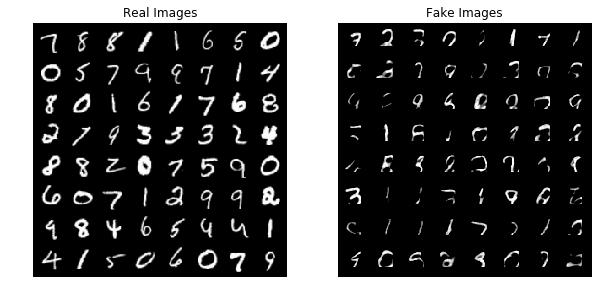

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(loader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

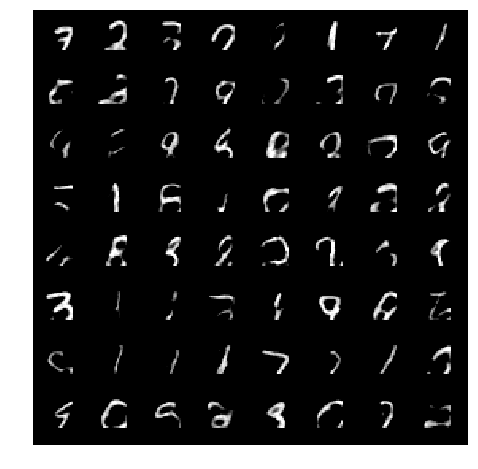

In [15]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, i)))] for i in range(1, trainer.epochs + 1)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Play the animation
HTML(ani.to_jshtml())